<a href="https://colab.research.google.com/github/PedramDbg/CS-MachineLearning/blob/main/Assignment_3/ML_HW_03_p1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem 1**: Design a convolutional neural network in Keras of at least 10 convolutional layers. Use the MNIST
dataset for evaluation. You must try three designs as detailed below and provide your observations on the performance of each:
1. A regular CNN where the number of filters in each layer increases as the depth of the network grows i.e., the Lth layer will have more filters than the (L-1)th layer.

2. An inverted CNN where the number of filters in each layer decreases as the depth of the network grows i.e., the Lth layer will have less filters than the (L-1)th layer.

3. An hour-glass shaped CNN where the number of filters will increase till the Lth layer and reduce afterwards.
Your goal is to design these networks and optimize them to their best performance by choosing the right hyperparameters for each network, such as the learning rate, batch size and the choice of optimizer (‘SGD’, ‘adam’, ‘RMSProp’). You must provide a detailed report of what values you tried for each hyperparameters, your observations on why the network performed well (or not)
and the final accuracy for each network on the MNIST dataset.

# Import libraries

In [ ]:
# import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from  torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchsummary import summary

# Preparing Data


In [ ]:
# acquire MNIST dataset
torch.manual_seed(123)

ds = MNIST(root='data/', download=True, train=True, transform=ToTensor())
ds_test = MNIST(root='data/', download=True, train=False, transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# Defining required functions


In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

print(get_default_device())

cuda


## Plot functions


In [ ]:
def plot_score(history, axs):
    acc = [x['val_acc'] for x in history]
    axs.plot(acc, '-o')
    axs.set_xlabel('epoch')
    axs.set_ylabel('acc')
    axs.set_title('Accuracy vs. number of epochs');

def plot_loss(history, axs):
    train_loss = [x.get('train_loss') for x in history]
    val_loss = [x['val_loss'] for x in history]
    axs.plot(train_loss, '-bo', label='Training')
    axs.plot(val_loss, '-go', label='Validation')
    axs.set_xlabel('epoch')
    axs.set_ylabel('loss')
    axs.legend()
    axs.set_title('Loss vs. number of epochs');

## Accuary function



In [ ]:
def accuracy(outputs, labels):
    _ , preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# The decorator defines whether the gradient parameters should be saved or not
# This can reduce the required memory and consequently speed up the computation.
@torch.no_grad()
def evaluate(model, val_loader):
    # instead of training mode, batchnorm or dropout layers will operate in eval mode
    model.eval()
    # determine the loss on the data from the validation set.
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)

    for epoch in range(epochs):
        # Training 
        model.train()
        train_loss = []
        for batch in train_loader:
            # calculate loss on training set
            loss = model.training_step(batch)
            # store losses
            train_loss.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_loss).mean().item()
        model.epoch_end(epoch, result,lr)
        history.append(result)
    return history

# Defining required classes


In [ ]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)


class MnistModelBase(torch.nn.Module):
    # calculate the training set's loss
    def training_step(self, batch):
        images, targets = batch   # features and labels
        out = self(images)        # output of the model
        loss = F.cross_entropy(out, targets) 
        return loss  
    
    # calculate the validation set's loss
    def validation_step(self, batch):
        images, targets = batch    # features and labels
        out = self(images)        # output of the model
        loss = F.cross_entropy(out, targets)
        # calculate the accuracy
        acc = accuracy(out, targets)
        # creat a dictionary containing loss and accuracy of validation set
        return {'val_loss': loss.detach(), 'val_acc': acc }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # stack losses
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()      # stack accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}


    def epoch_end(self, epoch, result,LR):
        print("Epoch [{}] - LR [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,LR,result['train_loss'], result['val_loss'], result['val_acc']))
        


**Problem 1**:
According to the findings, increasing filters have the highest accuracy on the validation set, whereas decreasing filters have the lowest accuracy. One needs run the models on a wide variety of hyperparameters in order to obtain more trustworthy results.

In [ ]:
class MnistModel1(MnistModelBase):
    def __init__(self):
        super().__init__()

        # size: (channel-in, channel-out, kernel size)
        self.conv1 = torch.nn.Conv2d(1, 4, 3, padding='same')
        self.conv2 = torch.nn.Conv2d(4, 8, 3, padding='same')
        self.conv3 = torch.nn.Conv2d(8, 12, 3, padding='same')
        self.conv4 = torch.nn.Conv2d(12, 16, 3, padding='same')
        self.conv5 = torch.nn.Conv2d(16, 20, 3, padding='same')
        self.conv6 = torch.nn.Conv2d(20, 24, 3, padding='same')
        self.conv7 = torch.nn.Conv2d(24, 26, 3, padding='same')
        self.conv8 = torch.nn.Conv2d(26, 28, 3, padding='same')
        self.conv9 = torch.nn.Conv2d(28, 30, 3, padding='same')
        self.conv10 = torch.nn.Conv2d(30, 32, 3)

        self.pool = torch.nn.MaxPool2d(2, 2)

        self.relu = torch.nn.ReLU()

        self.fc1 = torch.nn.Linear(5408, 100)
        self.fc2 = torch.nn.Linear(100, 10)  # 10 classes

    def forward(self, xb):

        # CNN
        x = self.relu(self.conv1(xb))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.relu(self.conv7(x))
        x = self.relu(self.conv8(x))
        x = self.relu(self.conv9(x))
        x = self.relu(self.conv10(x))
        x = self.pool(x)

        # MLP
        x = x.view(x.shape[0], -1)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

class MnistModel2(MnistModelBase):
    def __init__(self):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(1, 32, 3, padding='same')  # chnl-in, out, krnl
        self.conv2 = torch.nn.Conv2d(32, 30, 3, padding='same')
        self.conv3 = torch.nn.Conv2d(30, 28, 3, padding='same')
        self.conv4 = torch.nn.Conv2d(28, 26, 3, padding='same')
        self.conv5 = torch.nn.Conv2d(26, 24, 3, padding='same')
        self.conv6 = torch.nn.Conv2d(24, 20, 3, padding='same')
        self.conv7 = torch.nn.Conv2d(20, 16, 3, padding='same')
        self.conv8 = torch.nn.Conv2d(16, 12, 3, padding='same')
        self.conv9 = torch.nn.Conv2d(12, 8, 3, padding='same')
        self.conv10 = torch.nn.Conv2d(8, 4, 3, padding='same')
        self.pool = torch.nn.MaxPool2d(2, 2)

        self.relu = torch.nn.ReLU()

        self.fc1 = torch.nn.Linear(784, 100)
        self.fc2 = torch.nn.Linear(100, 10)  # 10 classes

    def forward(self, xb):

        # CNN
        x = self.relu(self.conv1(xb))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.relu(self.conv7(x))
        x = self.relu(self.conv8(x))
        x = self.relu(self.conv9(x))
        x = self.relu(self.conv10(x))
        x = self.pool(x)

        # MLP
        x = x.view(x.shape[0], -1)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

class MnistModel3(MnistModelBase):
    def __init__(self):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(1, 4, 3, padding='same')  # chnl-in, out, krnl
        self.conv2 = torch.nn.Conv2d(4, 8, 3, padding='same')
        self.conv3 = torch.nn.Conv2d(8, 16, 3, padding='same')
        self.conv4 = torch.nn.Conv2d(16, 32, 3, padding='same')
        self.conv5 = torch.nn.Conv2d(32, 64, 3, padding='same')

        self.conv6 = torch.nn.Conv2d(64, 32, 3, padding='same')
        self.conv7 = torch.nn.Conv2d(32, 16, 3, padding='same')
        self.conv8 = torch.nn.Conv2d(16, 8, 3, padding='same')
        self.conv9 = torch.nn.Conv2d(8, 4, 3, padding='same')
        self.conv10 = torch.nn.Conv2d(4, 1, 3)

        self.pool = torch.nn.MaxPool2d(2, 2)

        self.relu = torch.nn.ReLU()

        self.fc1 = torch.nn.Linear(169, 100)
        self.fc2 = torch.nn.Linear(100, 10)  # 10 classes

    def forward(self, xb):

        # CNN
        x = self.relu(self.conv1(xb))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.relu(self.conv7(x))
        x = self.relu(self.conv8(x))
        x = self.relu(self.conv9(x))
        x = self.relu(self.conv10(x))
        x = self.pool(x)

        # MLP
        x = x.view(x.shape[0], -1)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x
        

# Answer to the questions

**Part 1.** A regular CNN where the number of filters in each layer increases as the depth of the network grows i.e., the L th layer will have more filters than the (L-1) th layer.

Below, different models using different hyper parameters (learning rate, batch size and optimizer) are developed. 

The most accurate model was created using "n_batch": 128, "n_valid": 10000, "learn_rate": 0.001,  "opt_func": Adam. The validation accuracy, validation and training loss are as follow:

$val_{acc}: 0.9888671636581421$

$val_{loss}$: 0.04675213247537613

$train_{loss}$: 0.011170370504260063

On the other hand, the least accurate model was created using "n_batch": 128, "n_valid": 10000, "learn_rate": 0.001, "opt_func": SGD}

$val_{loss}$: 2.3022594451904297

$val_{acc}$: 0.11152343451976776

$train_{loss}$: 2.301741600036621

The number of epochs is set to be constant as it was seen that after around 10 epochs, all the models (with different hyperparameters) converge to acceptable values.

Epoch [0] - LR [0.001], train_loss: 0.4772, val_loss: 0.1066, val_acc: 0.9676
Epoch [1] - LR [0.001], train_loss: 0.0874, val_loss: 0.0705, val_acc: 0.9786
Epoch [2] - LR [0.001], train_loss: 0.0563, val_loss: 0.0568, val_acc: 0.9822
Epoch [3] - LR [0.001], train_loss: 0.0417, val_loss: 0.0635, val_acc: 0.9793
Epoch [4] - LR [0.001], train_loss: 0.0330, val_loss: 0.0518, val_acc: 0.9853
Epoch [5] - LR [0.001], train_loss: 0.0281, val_loss: 0.0475, val_acc: 0.9859
Epoch [6] - LR [0.001], train_loss: 0.0220, val_loss: 0.0410, val_acc: 0.9884
Epoch [7] - LR [0.001], train_loss: 0.0186, val_loss: 0.0399, val_acc: 0.9890
Epoch [8] - LR [0.001], train_loss: 0.0174, val_loss: 0.0419, val_acc: 0.9890
Epoch [9] - LR [0.001], train_loss: 0.0174, val_loss: 0.0451, val_acc: 0.9874
{'val_loss': 0.04514786973595619, 'val_acc': 0.9874023199081421, 'train_loss': 0.017405342310667038}
Epoch [0] - LR [0.001], train_loss: 1.1200, val_loss: 0.2034, val_acc: 0.9332
Epoch [1] - LR [0.001], train_loss: 0.141

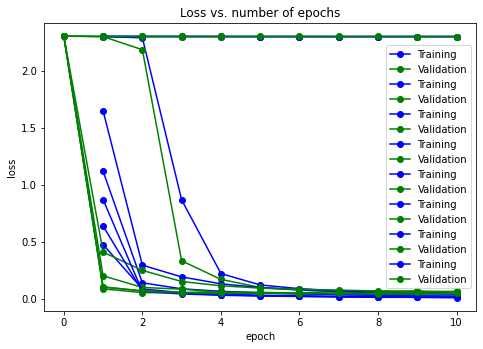

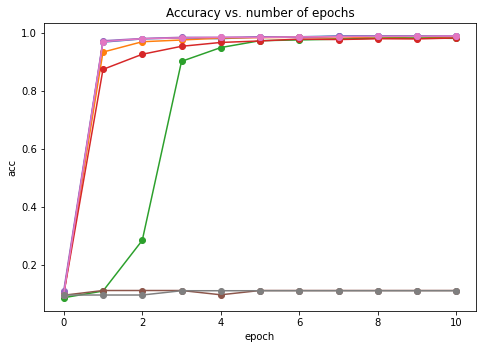

In [ ]:
# Defining hyper parameters list for a parameter study
n_epoch = 10
# the effect of different batch sizes
param_1 = {"n_batch": 128,  "n_valid": 10000, "epochs": n_epoch, "learn_rate": 0.001, "opt_func": torch.optim.Adam}
param_2 = {"n_batch": 256,  "n_valid": 10000, "epochs": n_epoch, "learn_rate": 0.001, "opt_func": torch.optim.Adam}
param_3 = {"n_batch": 1024, "n_valid": 10000, "epochs": n_epoch, "learn_rate": 0.001, "opt_func": torch.optim.Adam}
# the effect of different learning rates
param_4 = {"n_batch": 128, "n_valid": 10000, "epochs": n_epoch, "learn_rate": 0.0001, "opt_func": torch.optim.Adam}
param_5 = {"n_batch": 128, "n_valid": 10000, "epochs": n_epoch, "learn_rate": 0.001,  "opt_func": torch.optim.Adam}
param_6 = {"n_batch": 128, "n_valid": 10000, "epochs": n_epoch, "learn_rate": 0.01,   "opt_func": torch.optim.Adam}
# the effect of different optimizers (Adam & SGD)
param_7 = {"n_batch": 128, "n_valid": 10000, "epochs": n_epoch, "learn_rate": 0.001, "opt_func": torch.optim.Adam}
param_8 = {"n_batch": 128, "n_valid": 10000, "epochs": n_epoch, "learn_rate": 0.001, "opt_func": torch.optim.SGD}

# create a list of different scenarios
lst_param = [param_1, param_2, param_3, param_4, param_5, param_6, param_7, param_8]

fig1 = plt.figure()
axs1 = fig1.add_axes([0,0,1,1])
fig2 = plt.figure()
axs2 = fig2.add_axes([0,0,1,1])

for param in lst_param:
    n_valid = param["n_valid"]
    n_batch = param["n_batch"]
    epochs  = param["epochs"]
    learn_rate = param["learn_rate"]
    opt_func = param["opt_func"]

    n_train = len(ds) - n_valid 
    ds_train, ds_valid = random_split(ds, [n_train, n_valid]) # split dataset between two training and validation sets.

    device = get_default_device()

    train_loader = DataLoader(ds_train, n_batch, shuffle = True, num_workers = 2, pin_memory=True)
    val_loader   = DataLoader(ds_valid, 2 * n_batch, num_workers = 2, pin_memory=True)
    test_loader  = DataLoader(ds_test, 2 * n_batch, num_workers = 2, pin_memory=True)

    train_loader = DeviceDataLoader(train_loader, device)
    val_loader   = DeviceDataLoader(val_loader, device)
    test_loader  = DeviceDataLoader(test_loader, device)

    # Create model by building an object of MnistModel1 class
    model = MnistModel1()
    to_device(model, device)

    #summary(model, input_size=(1, 28, 28), batch_size=-1)

    # train the network
    history1 = [evaluate(model, val_loader)]
    history1 += fit(epochs, learn_rate, model, train_loader, val_loader, opt_func)

    plot_loss(history1, axs1)
    plot_score(history1, axs2)

    print(history1[-1])


**Part 2.** An inverted CNN where the number of filters in each layer decreases as the depth of the network grows i.e., the L th layer will have less filters than the (L-1) th layer.

Below, different models using different hyper parameters (learning rate, batch size and optimizer) are developed. 

The most accurate model was created using "n_batch": 128, "n_valid": 10000, "learn_rate": 0.001,  "opt_func": Adam. The validation accuracy, validation and training loss are as follow:

$val_{acc}: 0.986132800579071$

$val_{loss}$: 0.052851445972919464

$train_{loss}$: 0.01977604441344738

On the other hand, the least accurate model was created using "n_batch": 128, "n_valid": 10000, "learn_rate": 0.001, "opt_func": SGD}

$val_{acc}$: 0.10273437201976776

$val_{loss}$: 2.302386999130249

$train_{loss}$: 2.3028032779693604


The number of epochs is set to be constant as it was seen that after around 10 epochs, all the models (with different hyperparameters) converge to acceptable values.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 30, 28, 28]           8,670
              ReLU-4           [-1, 30, 28, 28]               0
            Conv2d-5           [-1, 28, 28, 28]           7,588
              ReLU-6           [-1, 28, 28, 28]               0
            Conv2d-7           [-1, 26, 28, 28]           6,578
              ReLU-8           [-1, 26, 28, 28]               0
            Conv2d-9           [-1, 24, 28, 28]           5,640
             ReLU-10           [-1, 24, 28, 28]               0
           Conv2d-11           [-1, 20, 28, 28]           4,340
             ReLU-12           [-1, 20, 28, 28]               0
           Conv2d-13           [-1, 16, 28, 28]           2,896
             ReLU-14           [-1, 16,

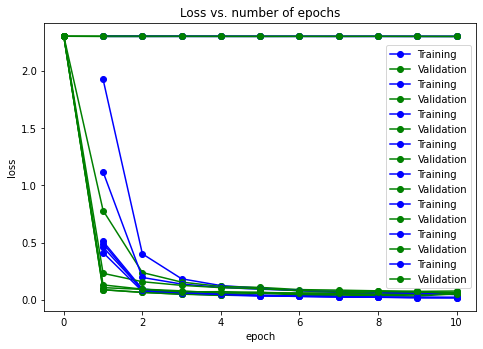

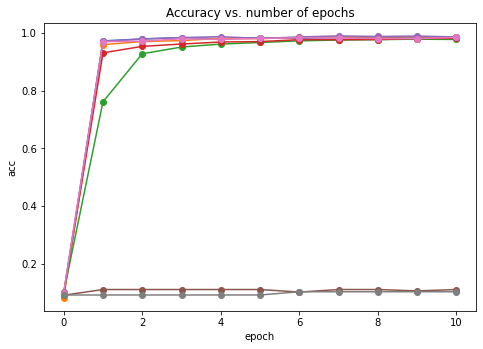

In [ ]:
# Defining hyper parameters list for a parameter study
n_epoch = 10
# the effect of different batch sizes
param_1 = {"n_batch": 128,  "n_valid": 10000, "epochs": n_epoch, "learn_rate": 0.001, "opt_func": torch.optim.Adam}
param_2 = {"n_batch": 256,  "n_valid": 10000, "epochs": n_epoch, "learn_rate": 0.001, "opt_func": torch.optim.Adam}
param_3 = {"n_batch": 1024, "n_valid": 10000, "epochs": n_epoch, "learn_rate": 0.001, "opt_func": torch.optim.Adam}
# the effect of different learning rates
param_4 = {"n_batch": 128, "n_valid": 10000, "epochs": n_epoch, "learn_rate": 0.0001, "opt_func": torch.optim.Adam}
param_5 = {"n_batch": 128, "n_valid": 10000, "epochs": n_epoch, "learn_rate": 0.001,  "opt_func": torch.optim.Adam}
param_6 = {"n_batch": 128, "n_valid": 10000, "epochs": n_epoch, "learn_rate": 0.01,   "opt_func": torch.optim.Adam}
# the effect of different optimizers (Adam & SGD)
param_7 = {"n_batch": 128, "n_valid": 10000, "epochs": n_epoch, "learn_rate": 0.001, "opt_func": torch.optim.Adam}
param_8 = {"n_batch": 128, "n_valid": 10000, "epochs": n_epoch, "learn_rate": 0.001, "opt_func": torch.optim.SGD}

lst_param = [param_1, param_2, param_3, param_4, param_5, param_6, param_7, param_8]

fig1 = plt.figure()
axs1 = fig1.add_axes([0,0,1,1])
fig2 = plt.figure()
axs2 = fig2.add_axes([0,0,1,1])

for param in lst_param:
    n_valid = param["n_valid"]
    n_batch = param["n_batch"]
    epochs  = param["epochs"]
    learn_rate = param["learn_rate"]
    opt_func = param["opt_func"]

    n_train = len(ds) - n_valid 
    ds_train, ds_valid = random_split(ds, [n_train, n_valid]) # split dataset between two training and validation sets.

    device = get_default_device()

    train_loader = DataLoader(ds_train, n_batch, shuffle = True, num_workers = 2, pin_memory=True)
    val_loader   = DataLoader(ds_valid, 2 * n_batch, num_workers = 2, pin_memory=True)
    test_loader  = DataLoader(ds_test, 2 * n_batch, num_workers = 2, pin_memory=True)

    train_loader = DeviceDataLoader(train_loader, device)
    val_loader   = DeviceDataLoader(val_loader, device)
    test_loader  = DeviceDataLoader(test_loader, device)

    # Create model by building an object of MnistModel1 class
    model = MnistModel2()
    to_device(model, device)

    summary(model, input_size=(1, 28, 28), batch_size=-1) # print the summary of the model

    # train the network
    history2 = [evaluate(model, val_loader)]
    history2 += fit(epochs, learn_rate, model, train_loader, val_loader, opt_func)

    plot_loss(history2, axs1)
    plot_score(history2, axs2)

    print(history2[-1])

**Part 3.** An hour-glass shaped CNN where the number of filters will increase till the L th layer and reduce afterwards.

Below, different models using different hyper parameters (learning rate, batch size and optimizer) are developed. 

The most accurate model was created using "n_batch": 128, "n_valid": 10000, "learn_rate": 0.001,  "opt_func": Adam. The validation accuracy, validation and training loss are as follow:

$val_{acc}: 0.9784179925918579$

$val_{loss}$: 0.07220704853534698

$train_{loss}$: 0.04695586860179901

On the other hand, the least accurate model was created using "n_batch": 128, "n_valid": 10000, "learn_rate": 0.001, "opt_func": SGD}

$val_{acc}$: 0.09882812201976776

$val_{loss}$: 2.302741289138794

$train_{loss}$: 2.302508592605591

The number of epochs is set to be constant as it was seen that after around 10 epochs, all the models (with different hyperparameters) converge to acceptable values.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
              ReLU-2            [-1, 4, 28, 28]               0
            Conv2d-3            [-1, 8, 28, 28]             296
              ReLU-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,168
              ReLU-6           [-1, 16, 28, 28]               0
            Conv2d-7           [-1, 32, 28, 28]           4,640
              ReLU-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 64, 28, 28]          18,496
             ReLU-10           [-1, 64, 28, 28]               0
           Conv2d-11           [-1, 32, 28, 28]          18,464
             ReLU-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 16, 28, 28]           4,624
             ReLU-14           [-1, 16,

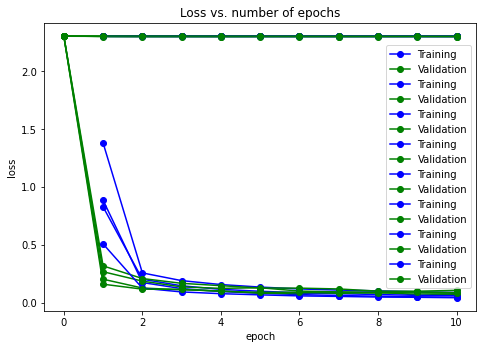

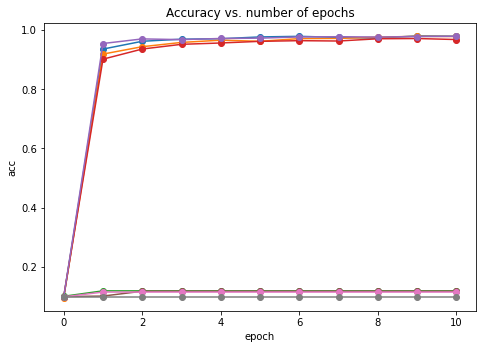

In [ ]:
# Defining hyper parameters list for a parameter study
n_epoch = 10
# the effect of different batch sizes
param_1 = {"n_batch": 128,  "n_valid": 10000, "epochs": n_epoch, "learn_rate": 0.001, "opt_func": torch.optim.Adam}
param_2 = {"n_batch": 256,  "n_valid": 10000, "epochs": n_epoch, "learn_rate": 0.001, "opt_func": torch.optim.Adam}
param_3 = {"n_batch": 1024, "n_valid": 10000, "epochs": n_epoch, "learn_rate": 0.001, "opt_func": torch.optim.Adam}
# the effect of different learning rates
param_4 = {"n_batch": 128, "n_valid": 10000, "epochs": n_epoch, "learn_rate": 0.0001, "opt_func": torch.optim.Adam}
param_5 = {"n_batch": 128, "n_valid": 10000, "epochs": n_epoch, "learn_rate": 0.001,  "opt_func": torch.optim.Adam}
param_6 = {"n_batch": 128, "n_valid": 10000, "epochs": n_epoch, "learn_rate": 0.01,   "opt_func": torch.optim.Adam}
# the effect of different optimizers (Adam & SGD)
param_7 = {"n_batch": 128, "n_valid": 10000, "epochs": n_epoch, "learn_rate": 0.001, "opt_func": torch.optim.Adam}
param_8 = {"n_batch": 128, "n_valid": 10000, "epochs": n_epoch, "learn_rate": 0.001, "opt_func": torch.optim.SGD}

lst_param = [param_1, param_2, param_3, param_4, param_5, param_6, param_7, param_8]

fig1 = plt.figure()
axs1 = fig1.add_axes([0,0,1,1])
fig2 = plt.figure()
axs2 = fig2.add_axes([0,0,1,1])

for param in lst_param:
    n_valid = param["n_valid"]
    n_batch = param["n_batch"]
    epochs  = param["epochs"]
    learn_rate = param["learn_rate"]
    opt_func = param["opt_func"]

    n_train = len(ds) - n_valid 
    ds_train, ds_valid = random_split(ds, [n_train, n_valid]) # split dataset between two training and validation sets.

    device = get_default_device()

    train_loader = DataLoader(ds_train, n_batch, shuffle = True, num_workers = 2, pin_memory=True)
    val_loader   = DataLoader(ds_valid, 2 * n_batch, num_workers = 2, pin_memory=True)
    test_loader  = DataLoader(ds_test, 2 * n_batch, num_workers = 2, pin_memory=True)

    train_loader = DeviceDataLoader(train_loader, device)
    val_loader   = DeviceDataLoader(val_loader, device)
    test_loader  = DeviceDataLoader(test_loader, device)

    # Create model by building an object of MnistModel1 class
    model = MnistModel3()
    to_device(model, device)

    summary(model, input_size=(1, 28, 28), batch_size=-1) # print the summary of the model

    # train the network
    history3 = [evaluate(model, val_loader)]
    history3 += fit(epochs, learn_rate, model, train_loader, val_loader, opt_func)

    plot_loss(history3, axs1)
    plot_score(history3, axs2)

    print(history3[-1])